In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import sys
sys.path.append('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/utils')
from pp_utils import *
from plot_utils import *
from mTRF_utils import *
from midi_utils import *
from update_sub_lists import*
from ERP_utils import *

In [135]:
def generate_sv_onset(file):
    """ 
    Generates a support vector for mTRF analyses
    """
    data = pd.read_csv(file)
    ktimes = data['time']
    sv = np.zeros(76800) #length of the 10min file at 128 hz
    sv[ktimes] = 1

    return sv

def generate_sv_firsts(file, other_value = 0.7):
    """ 
    Support vector where the firsts keystrokes are 1 and the others are some other value. 
    other_value: value of the other keystrokes
    """
    
    data = pd.read_csv(file)

    ftimes = data[data['type'] == 'first']['time']
    otimes = data[data['type'] == 'other']['time']

    sv = np.zeros(76800) #length of the 10min file at 128 hz
    
    sv[ftimes] = 1
    sv[otimes] = other_value

    return sv


def normalize_1d(x):
    """ 
    Normalizes a 1d array to be between 0 and 1
    """
    x_norm = x/np.max(x)
    #x_norm = (x-np.min(x))/(np.max(x)-np.min(x))

    return x_norm

def generate_sv_firsts_sur(file, normalize = True):
    """ 
    Support vector where the firsts keystrokes are 1*n_prev_keystrokes and the others are 0.5 (can customize later). 
    other_value: value of the other keystrokes
    """
    
    data = pd.read_csv(file)

    firsts = data[data['type'] == 'first']
    otimes = data[data['type'] == 'other']['time']

    sv = np.zeros(76800) #length of the 10min file at 128 hz
    
    for _, row in firsts.iterrows():
        
        ftime = row['time']
        
        f_prev = row['prev_keystrokes']
        if f_prev > 0:
            sv[ftime] = f_prev
        else:
            sv[ftime] = 0.8 #set value to something intermediate if the previous keystroke was also a first
    
    sv[otimes] = 0.5

    if normalize: 
        sv = normalize_1d(sv)
    

    return sv

def generate_sv_onsets_sur(file, normalize = True, a = 0.8, k = 0.7):
    """ 
    Support vector where the firsts keystrokes are 1 and the value of others decay as a function of the number of previous keystrokes
    (the others decay exponentially)
    a: initial value (i.e. the first 'other' after a map change aka the second keystroke after map change)
    k: decay constant
    """
    
    data = pd.read_csv(file)

    ftimes = data[data['type'] == 'first']['time']
    others = data[data['type'] == 'other']

    sv = np.zeros(76800) #length of the 10min file at 128 hz
    
    for _, row in others.iterrows():
        
        otime = row['time']
        o_since = row['keystrokes_since']
        sv[otime] = a-k*(1-np.exp(-(k*o_since)))
    
    sv[ftimes] = 1

    if normalize: 
        sv = normalize_1d(sv)
    

    return sv


def generate_sv_fo_sur(file, normalize = True, a = 0.7, k = 0.7):
    """ 
    Support vector where the firsts keystrokes are 1 and the value of others decay as a function of the number of previous keystrokes
    (the others decay exponentially)
    a: initial value (i.e. the first 'other' after a map change aka the second keystroke after map change)
    k: decay constant
    """
    
    data = pd.read_csv(file)

    firsts = data[data['type'] == 'first']
    others = data[data['type'] == 'other']

    sv = np.zeros(76800) #length of the 10min file at 128 hz
    
    for _, row in others.iterrows():
        
        otime = row['time']
        o_since = row['keystrokes_since']
        sv[otime] = a-k*(1-np.exp(-(k*o_since)))
    
    for _, row in firsts.iterrows():
        
        ftime = row['time']
        f_prev = row['prev_keystrokes']
        if f_prev > 0:
           
            sv[ftime] = f_prev
        else:
            sv[ftime] = 0.9

    if normalize: 
        sv = normalize_1d(sv)
    
    return sv

## Batch process support vectors

In [119]:

good_listen_subjects, good_motor_subjects,good_error_subjects,musicians,nonmusicians = load_subject_lists_LME()
subjects_to_process = good_error_subjects


In [172]:
sv_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/sv'
keystroke_path = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected_since'

periods = ['pre', 'post']

for sub in subjects_to_process:
    for period in periods:
        keystroke_file = os.path.join(keystroke_path, f'mapchange_keystrokes_{period}_{sub}.csv')

        sv = generate_sv_onset(keystroke_file)
        fsv = generate_sv_firsts(keystroke_file, other_value=0.8)
        fssv = generate_sv_firsts_sur(keystroke_file)
        ossv = generate_sv_onsets_sur(keystroke_file)
        fossv = generate_sv_fo_sur(keystroke_file)
        
        sv_data = {
            'onsets':sv,
            'firsts': fsv,
            'firsts_sur':fssv,
            'onsets_sur': ossv,
            'fo_sur':fossv
        }

        savemat(f"{sv_path}/sv_data_{period}_{sub}.mat", sv_data)


## Generate figures for slides

In [123]:
fsv = loadmat('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/sv/sv_data_post_08.mat')['firsts'][0]
osv = loadmat('/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mtrf_error_surprise/sv/sv_data_post_08.mat')['onsets'][0]

In [124]:
keystroke_file = '/Users/cindyzhang/Documents/M2/Audiomotor_Piano/AM-EEG/analysis_error/mapchange_csv_corrected_since/mapchange_keystrokes_post_08.csv'

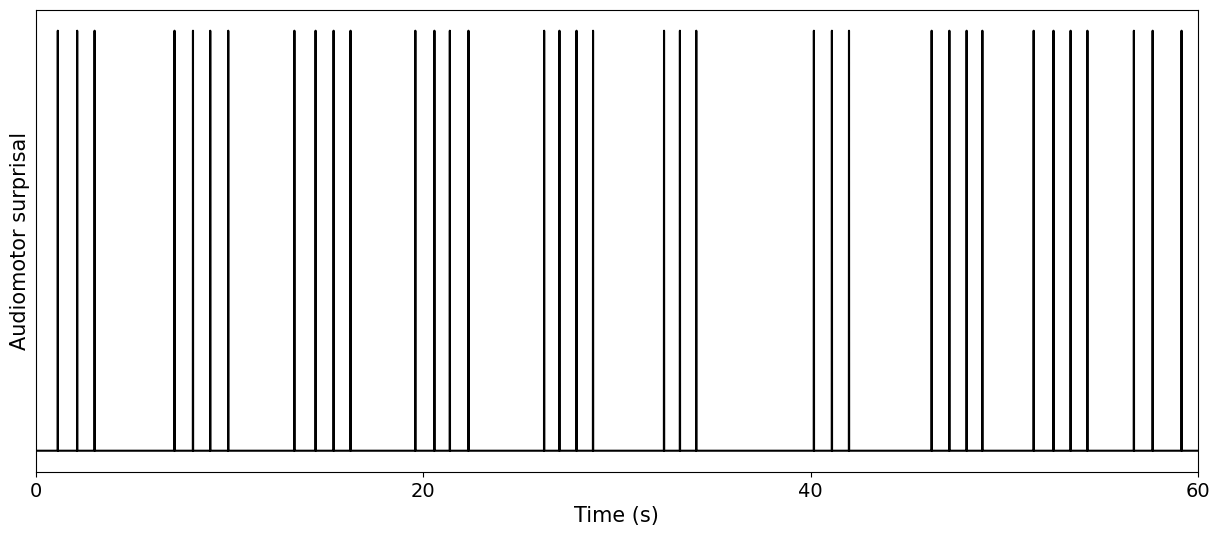

In [125]:
plt.figure(figsize = (15,6))
plt.plot(osv, color = 'black')
plt.xlim(0,7680)

xtimes =[ x*128 for x in [0,20, 40, 60]]
plt.xticks(xtimes, fontsize = 14)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x /128:.0f}')) 
plt.xlabel('Time (s)',  fontsize = 15)
plt.yticks([])
plt.ylabel('Audiomotor surprisal', fontsize = 15)
plt.savefig('surprise_firsts.svg')

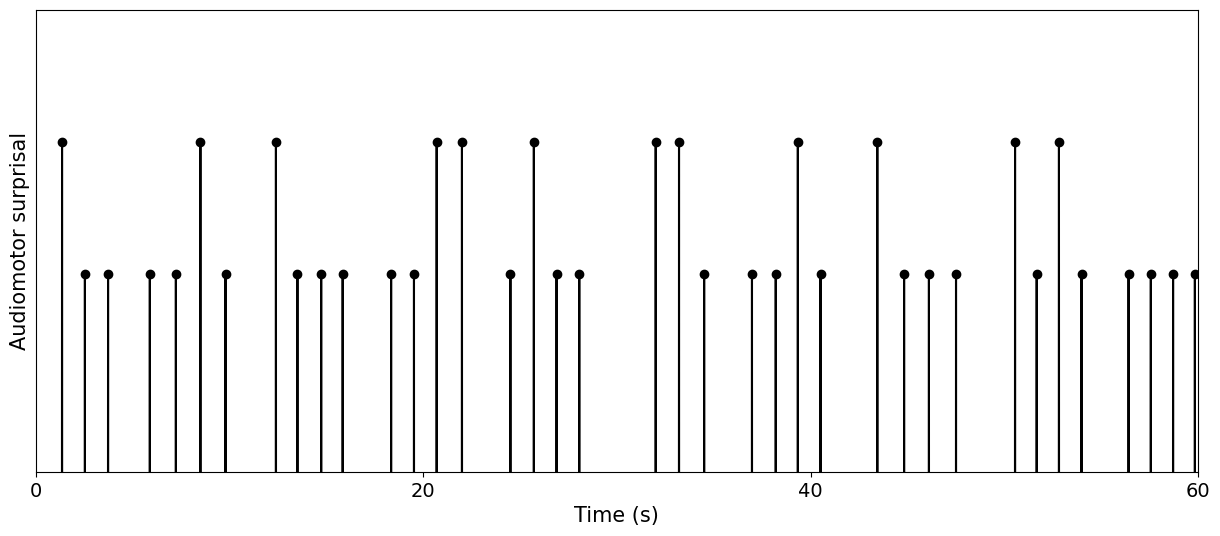

In [180]:

plt.figure(figsize = (15,6))
plt.plot(fsv, color = 'black', marker = 'o')
plt.xlim(0,7680)

xtimes =[ x*128 for x in [0,20, 40, 60]]
plt.xticks(xtimes, fontsize = 14)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x /128:.0f}')) 
plt.xlabel('Time (s)',  fontsize = 15)

plt.ylim(0.5,1.2)
plt.yticks([])
plt.ylabel('Audiomotor surprisal', fontsize = 15)
plt.savefig('surprise_firsts.svg')

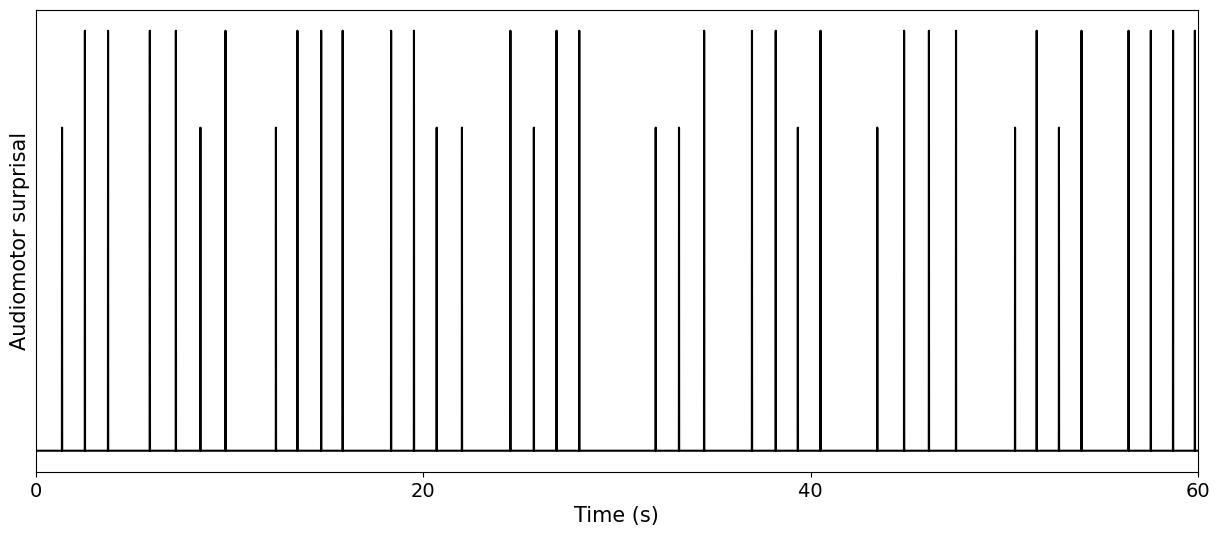

In [137]:


plt.figure(figsize = (15,6))
plt.plot(fsv, color = 'black')
plt.xlim(0,7680)

xtimes =[ x*128 for x in [0,20, 40, 60]]
plt.xticks(xtimes, fontsize = 14)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x /128:.0f}')) 
plt.xlabel('Time (s)',  fontsize = 15)
plt.yticks([])
plt.ylabel('Audiomotor surprisal', fontsize = 15)
plt.savefig('surprise_firsts.svg')

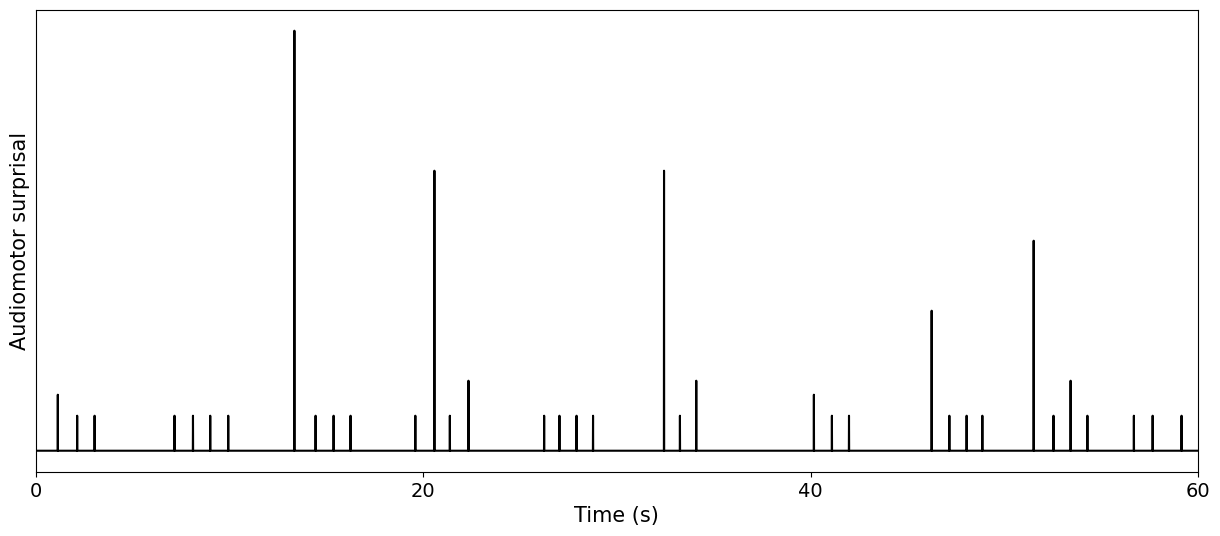

In [128]:
sv_fs = generate_sv_firsts_sur(keystroke_file)
plt.figure(figsize = (15,6))
plt.plot(sv_fs[0:7680], color = 'black')
plt.xlim(0,7680)

xtimes =[ x*128 for x in [0,20, 40, 60]]
plt.xticks(xtimes, fontsize = 14)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x /128:.0f}')) 
plt.xlabel('Time (s)',  fontsize = 15)
plt.yticks([])
plt.ylabel('Audiomotor surprisal', fontsize = 15)
plt.savefig('surprise_firsts.svg')

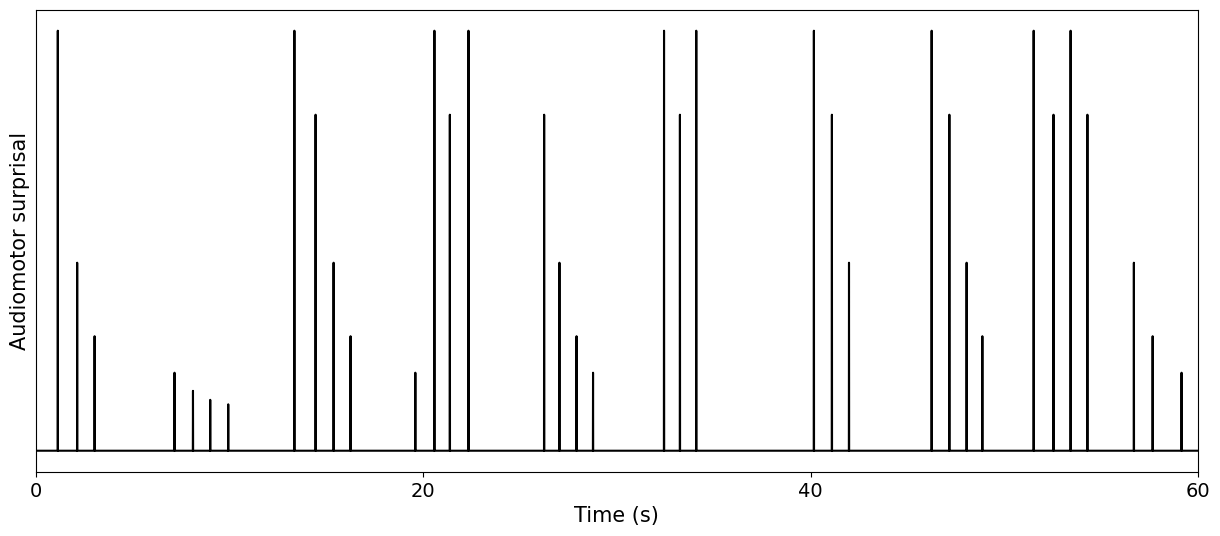

In [129]:


sso = generate_sv_onsets_sur(keystroke_file)

plt.figure(figsize = (15,6))
plt.plot(sso, color = 'black')
plt.xlim(0,7680)


xtimes =[ x*128 for x in [0,20, 40, 60]]
plt.xticks(xtimes, fontsize = 14)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x /128:.0f}')) 
plt.xlabel('Time (s)',  fontsize = 15)
plt.yticks([])
plt.ylabel('Audiomotor surprisal', fontsize = 15)
plt.savefig('surprise_firsts.svg')

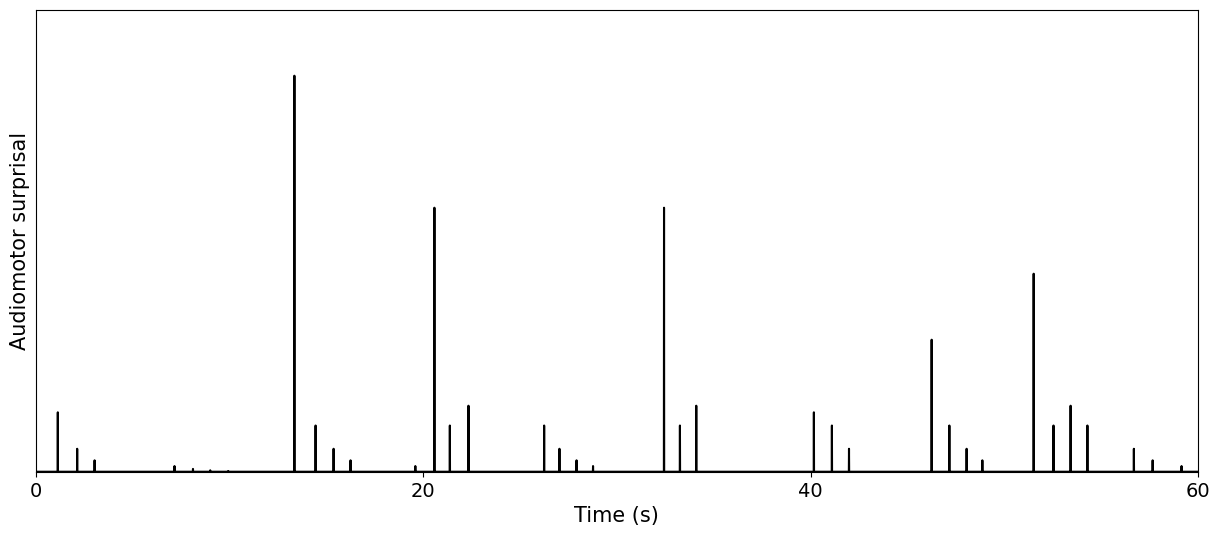

In [130]:


ssfo = generate_sv_fo_sur(keystroke_file)

plt.figure(figsize = (15,6))
plt.plot(ssfo, color = 'black')
plt.xlim(0,7680)
plt.ylim(0, 0.5)

xtimes =[ x*128 for x in [0,20, 40, 60]]
plt.xticks(xtimes, fontsize = 14)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x /128:.0f}')) 
plt.xlabel('Time (s)',  fontsize = 15)
plt.yticks([])
plt.ylabel('Audiomotor surprisal', fontsize = 15)
plt.savefig('surprise_firsts.svg')